In [2]:
import pandas as pd
import re
import numpy as np

In [3]:
class preprocess_news:    
        
    def __init__(self, stock_num, stock_name, file_count = 1):
        self.stock_path = "Data/주가/" #jjin
        self.news_path = "Data/news_raw/" #jjin
        
#         self.stock_path = "자료/days/num_name/"
#         self.news_path = "자료/news_raw/"
        self.stock_num = stock_num
        self.stock_name = stock_name
        self.file_count = file_count               

    # 첫번째 news 처리    
    def news_pre1(self):
        if self.file_count == 1:
            news = pd.read_excel("{}{}_{}.xlsx".format(self.news_path,self.stock_num,self.stock_name), 
                                      encoding = "utf-8", converters={'뉴스 식별자':str})            
        else:
            for i in range(1,self.file_count+1):
                temp = pd.read_excel("{}{}_{}_0{}.xlsx".format(self.news_path,self.stock_num,self.stock_name,i), 
                                      encoding = "utf-8", converters={'뉴스 식별자':str})       
                if i == 1:
                    news = temp
                else:
                    news = news.append(temp)
        
        news = news[news['뉴스 식별자'].str.len() == (26)] # 값이 잘못 된 데이터 삭제
        news['일자시간'] = news['뉴스 식별자'].apply(lambda x: str(x)[-17:-5]) # 일자시간 추가
        news = news.loc[:, (['일자시간','키워드'])] # 필요한 컬럼만 선택
        news = news.sort_values(by = ['일자시간']).reset_index(drop=True) # 일자시간 오름차순으로 재정렬
        return news
    
    def hangul(self,news): # 알파벳, 숫자, 한자, 특수기호 제거 (추가 0904, 진영)
        for i in range(len(news)):
            ky = news.iloc[i].키워드
            alphabet = re.compile('[a-zA-Z0-9一-龥]+')
            number = re.compile('[0-9一-龥]+')
            result = number.sub("", ky)
            special = re.compile('[-=.#/?:$}/%~ㆍ・&]+')
            result = special.sub("", result)
            elseword = re.compile('[㈜(주)ㄱㄴ]')
            result = elseword.sub("", result)
            news.loc[i, '키워드'] = result
        return news
    
    def keyword_remove(self,news): #기업 이름 제거, 직책명, 단위 등 제거 (추가 0904, 진영)
        for i in range(len(news)):
            stock_name = self.stock_name
            word = news.iloc[i].키워드.split(',')            

            # '한화'가 들어간 모든 키워드 제거(그룹사명 제거)
            pattern = re.compile('[^%s]' % stock_name)
            no_company = []
            for j in word:
                if pattern.match(j):
                    no_company.append(j)

            # 직책명, 단위 등 제거
            role_name = ['회장', '부회장', '사장', '부사장', '대표', 'CEO', '전무', '상무', '대표이사', 
                         '원', '십', '백', '천', '만', '억', '십억', '백억', '천억', '조', '일', '월', '년', '명', '세', '배']
            for j in no_company:
                if j in role_name:
                    no_company.remove(j)

            # 글자가 없는 스트링 제거 (or 연산으로 처리가 안돼서 두번 for문 작업함)
            for j in no_company:
                if len(j) == 1:
                    no_company.remove(j)
            for j in no_company:
                if len(j) == 0:
                    no_company.remove(j)  

            # 리스트를 다시 스트링으로 전환하여 원본 데이터에 삽입
            result = ','.join(no_company)
            #result = not_company_name
            news.loc[i, '키워드'] = result
        return news
    

    def news_9to9(self, news):
        stock = self.get_stock()
        stock.loc[:,'일자9'] = stock['date'].apply(lambda x: int(str(x) + '0900'))        
        news.loc[:,"date"] = pd.cut(news['일자시간'].astype('float'), stock['일자9'])
        news = news.dropna(how='any', axis=0)
        news.loc[:,"date"] = news.loc[:,"date"].apply(lambda x: int(str(x)[14:23]))
        return news
    
    def news_8to8(self, news):
        stock = self.get_stock()
        stock.loc[:,'일자9'] = stock['date'].apply(lambda x: int(str(x) + '0800'))        
        news.loc[:,"date"] = pd.cut(news['일자시간'].astype('float'), stock['일자9'])
        news = news.dropna(how='any', axis=0)
        news.loc[:,"date"] = news.loc[:,"date"].apply(lambda x: int(str(x)[14:23]))
        return news    

    
    
    
    def train_test(self, news):
        index_date = '20180330'
        train = news.loc[:index_date]
        test = news.loc[index_date:]
        return train, test
    

    
    # 전날 15:30에서 당일 9시 전까지 동일 id 부여
    def news_1530to9(self, news):

        news['시간'] = news['일자시간'].apply(lambda x: int(str(x)[-4:]))
        news = news[(news['시간']<900) | (news['시간']>1530)]
        news = news.drop(['시간'], axis=1)
        
        stock = self.get_stock()
        stock['일자9'] = stock['date'].apply(lambda x: int(str(x) + '0900'))        
        news["date"] = pd.cut(news['일자시간'].astype('float'), stock['일자9'])
        news = news.dropna(how='any', axis=0)
        news.loc[:,"date"] = news.loc[:,"date"].apply(lambda x: int(str(x)[14:23]))
        return news
    
    def news_1530to8(self, news):

        news['시간'] = news['일자시간'].apply(lambda x: int(str(x)[-4:]))
        news = news[(news['시간']<800) | (news['시간']>1530)]
        news = news.drop(['시간'], axis=1)
        
        stock = self.get_stock()
        stock['일자9'] = stock['date'].apply(lambda x: int(str(x) + '0800'))        
        news["date"] = pd.cut(news['일자시간'].astype('float'), stock['일자9'])
        news = news.dropna(how='any', axis=0)
        news.loc[:,"date"] = news.loc[:,"date"].apply(lambda x: int(str(x)[14:23]))
        return news
    
#     def vectorize(self, news, n= 5):
#         from sklearn.feature_extraction.text import CountVectorizer
#         vectorizer = CountVectorizer()
#         X = vectorizer.fit_transform(news.loc[:, '키워드'])
#         keywords = vectorizer.get_feature_names()
#         X = X.toarray()
#         X = pd.DataFrame(data = X, columns = keywords)
#         X.drop([col for col, val in X.sum().iteritems() if val <= n], axis=1, inplace=True)
#         return X
    
    # 키워드가 칼럼인 sparce matrix 만들기
    # 전체 n개 이하 키워드는 삭제, 기본은 5개
    def make_s_matrix(self, news, n = 5):
        stock = self.get_stock()
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(news.loc[:, '키워드'])
        keywords = vectorizer.get_feature_names()
        X = X.toarray()
        X = pd.DataFrame(data = X, columns = keywords)
        X.drop([col for col, val in X.sum().iteritems() if val <= n], axis=1, inplace=True)
        news = pd.concat([news['date'], X],axis=1)        
        news = news.groupby(['date']).sum()
        news = pd.concat([news, stock.set_index('date')['new_Up']], axis=1) # 주가 상승 여부를 마지막에 넣어줌 
        news = news.dropna(axis=0)
        return news
    
    def tfidf(self, news, n = 5):
        stock = self.get_stock()
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(news.loc[:, '키워드'])
        keywords = vectorizer.get_feature_names()
        
        from sklearn.feature_extraction.text import TfidfTransformer
        transformer = TfidfTransformer(smooth_idf=False)
        tfidf = transformer.fit_transform(X.toarray())
        X = tfidf.toarray()

        X = pd.DataFrame(data = X, columns = keywords)
        news = pd.concat([news['date'], X],axis=1)        
        news = news.groupby(['date']).sum()
        news = pd.concat([news, stock.set_index('date')['new_Up']], axis=1) # 주가 상승 여부를 마지막에 넣어줌 
        news = news.dropna(axis=0)
        return news
    
    
       
    def get_stock(self):
        stock = pd.read_excel("{}{}_{}.xlsx".format(self.stock_path,self.stock_num,self.stock_name)) 
        lst = [1000]
        for i in range(1, len(stock)):
            if stock.iloc[i-1].close*1.01  <= stock.iloc[i].close:
                lst.append(1)
            elif stock.iloc[i-1].close*0.99  >= stock.iloc[i].close:
                lst.append(-1)
#                 lst.append(0)
            else:
                lst.append(0)
        stock['new_Up'] = lst
        return stock
        
        return(stock)
 #######  NEW   ###########   
    def train_word_power(self, train):
#         train = train.set_index('date')
        positive = train[train['new_Up']==1]
        negative = train[train['new_Up'] == -1]
        posDF = pd.DataFrame(columns = positive.columns, index = ['count'])
        negDF = pd.DataFrame(columns = negative.columns, index = ['count'])
        del posDF['new_Up']
        del negDF['new_Up']
        
        for i in posDF.columns:
            posDF[i] = float(positive[i].sum())
#             print("posdf", i, posDF[i])

        for i in negDF.columns:
            negDF[i] = float(-negative[i].sum())
        total = posDF.add(negDF)
        sum_num = pd.DataFrame(train.sum(axis =0)).T
        sum_num = sum_num.iloc[:,:-1]
        
        power = total.div(sum_num.iloc[0]).fillna(0)
        
        return power
    
    def train_emo_dic(self, power):
        neg_dic = list()
        pos_dic = list()
        for i in power.columns:
            if power[i][0] < 0:
                neg_dic.append(i)
            else:
                pos_dic.append(i)
        return neg_dic, pos_dic
    
    def train_score(self, train, power):
#         train = train.set_index('date')
        emo_train = train.iloc[:,:-1].astype('float')
        for article in emo_train.index:
            emo_train.loc[article] = (emo_train.loc[article]*power).values  #각 단어의 빈도수 * +1 or -1
    
        emo_train['new_Up'] = train['new_Up']
        emo_train['score'] = 0

        for i in emo_train.index:
            emo_train.at[i,'score'] = emo_train.loc[i].sum()
        return emo_train
    
    # 진영 추가. 각 감성지수를 사전으로 만들기
    def sentiment_dictionary(self, power):
        sentiment_dict = power.to_dict('records')
        return sentiment_dict[0]
        

    
    def train_confusion(self, train, emo_train,n = 1):
#         train = train.set_index('date')
        check = pd.concat([emo_train['score'], train['new_Up'].astype('float')], axis = 1)

        self.std = np.std(emo_train.score.values)
        self.mean = np.mean(emo_train.score.values)
        
        self.lower = self.mean - n*self.std
        self.upper = self.mean + n*self.std
        
        check['score'] = check['score'].apply(lambda x: 1 if x > self.upper else -1 if x<self.lower else 0)

        conf = pd.crosstab(check['score'].values, check['new_Up'].values)
        corr_sum = sum(conf.iloc[i,i] for i in range(len(conf)))/len(check)
        return corr_sum
    
    def test_score(self, power, test, emo_train):
        #test = test.set_index('date')
        emo_test = test.iloc[:,:-1].astype('float')
        test_columns = emo_test.columns.values
        train_columns = emo_train.columns.values
        
        common = np.intersect1d(test_columns, train_columns)
        
        emo_test = test[common].astype('float')
        test_power = power[common]
        
        for article in emo_test.index:
            emo_test.loc[article] = (emo_test.loc[article]*test_power).values  #각 단어의 빈도수 * +1 or -1
        emo_test['new_Up'] = test['new_Up']
        emo_test['score'] = 0
        
        for i in emo_test.index:
            emo_test.at[i,'score'] = emo_test.loc[i].sum()
        return emo_test
    
    def test_confusion(self,test, emo_test):
#         test = test.set_index('date')
        test_check = pd.concat([emo_test['score'], test['new_Up'].astype('float')], axis = 1)
        
        #self.stdt = np.std(emo_test.score.values)
        #self.meant = np.mean(emo_test.score.values)
        
        #self.lowert = self.meant - self.stdt
        #self.uppert = self.meant + self.stdt
        
        #기존의 train data의 upper, lower을 사용
        test_check['score'] = test_check['score'].apply(lambda x: 1 if x > self.upper else -1 if x<self.lower else 0)

        t_conf = pd.crosstab(test_check['score'].values, test_check['new_Up'].values)
        print(t_conf)
        corr_sum = sum(t_conf.iloc[i,i] for i in range(len(t_conf)))/len(test_check)
        return corr_sum

In [4]:
a = preprocess_news('034','기업은행')
news = a.news_pre1()
news = a.hangul(news)
news = a.keyword_remove(news)

In [5]:
# news = a.news_9to9(news)
news = a.news_8to8(news)

C:\Users\renz\AppData\Local\conda\conda\envs\tensorflow3.6.5\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
# 여기서 변경

In [8]:
news = a.make_s_matrix(news)
# news = a.tfidf(news)

In [10]:
train, test = a.train_test(news)


In [13]:
X_train = train.iloc[:,:-1]
y_train = train['new_Up']
X_test = test.iloc[:,:-1]
y_test = test['new_Up']

In [14]:
train.iloc[30:40, -13:]

,희망퇴직금,희망퇴직제도,희망홀씨,희망홀씨대출,희비,희생,희석,희소성,히트,히트상품,힌트,힐링,new_Up
date,,,,,,,,,,,,,
20170913,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
20170914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
20170915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20170918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0
20170919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0
20170920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0
20170921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
20170922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
20170925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [15]:
X_train

,aa,aaa,abcp,aber,abl,abl생명,abs,access,account,accounts,...,희망홀씨,희망홀씨대출,희비,희생,희석,희소성,히트,히트상품,힌트,힐링
date,,,,,,,,,,,,,,,,,,,,,
20170801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170804,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170807,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20170808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170809,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 감성사전

In [12]:
power = a.train_word_power(train)
# senti_dict = a.sentiment_dictionary(power)
# power

In [13]:
train_scored =  a.train_score(train, power)

In [14]:
test_scored = a.test_score(power, test, train_scored)

In [15]:
train_scored.iloc[30:40, -14:]

,희망퇴직금,희망퇴직제도,희망홀씨,희망홀씨대출,희비,희생,희석,희소성,히트,히트상품,힌트,힐링,new_Up,score
date,,,,,,,,,,,,,,
20170913,0.0,0.0,-0.0,-0.0,0.0,0.0,0.166667,0.0,-0.0,0.0,-0.0,-0.0,0,158
20170914,0.0,0.0,-0.0,-0.0,0.0,0.0,0.000000,0.0,-0.0,0.0,-0.0,-0.0,0,99
20170915,0.0,0.0,-0.0,-0.0,0.0,0.0,0.000000,0.0,-0.0,0.0,-0.0,-0.0,1,226
20170918,0.0,0.0,-0.0,-0.0,0.0,0.0,0.000000,0.0,-0.0,0.0,-0.0,-0.0,0,100
20170919,0.0,0.0,-0.0,-0.0,0.0,0.0,0.000000,0.0,-0.0,0.0,-0.0,-0.0,0,142
20170920,0.0,0.0,-0.0,-0.0,0.0,0.0,0.000000,0.0,-0.0,0.0,-0.0,-0.0,0,67
20170921,0.0,0.0,-0.0,-0.0,0.0,0.0,0.000000,0.0,-0.0,0.0,-0.0,-0.0,0,104
20170922,0.0,0.0,-0.0,-0.0,0.0,0.0,0.000000,0.0,-0.0,0.0,-0.6,-0.0,1,383
20170925,0.0,0.0,-0.0,-0.0,0.0,0.0,0.000000,0.0,-0.0,0.0,-0.0,-0.0,-1,-229


In [16]:
# X_train = np.array(train_scored['score']).reshape(-1,1)
# y_train = train_scored['new_Up']
# X_test = np.array(test_scored['score']).reshape(-1,1)
# y_test = test_scored['new_Up']

In [17]:
X_train = train_scored.iloc[:,:-2]
y_train = train_scored['new_Up']

In [18]:
X_test = test_scored.iloc[:,:-2] 
y_test = test_scored['new_Up']

# 한글 폰트

In [19]:
from matplotlib import font_manager
font_manager.findfont('NanumGothic')


C:\Users\renz\AppData\Local\conda\conda\envs\tensorflow3.6.5\lib\site-packages\matplotlib\font_manager.py:1238: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


'C:\\Users\\renz\\AppData\\Local\\conda\\conda\\envs\\tensorflow3.6.5\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'

In [21]:
from matplotlib import font_manager, rc
font_location = "Data/font/NanumGothic.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family="NanumGothic")

FileNotFoundError: [Errno 2] No such file or directory: 'Data/font/NanumGothic.ttf'

# 분석 및 결과

In [22]:
def preddd(pred):
    predicted = pd.DataFrame(pred, index = X_test.index, columns = ['predicted'])
    stock = a.get_stock()
    stock = stock.set_index('date', drop=True).drop('index',axis=1)
    predicted = predicted.join(stock, how='inner')
    predicted['money'] = predicted['close'] - predicted['open']
    print('총 종가 - 시가:', predicted['money'].sum())
    predicted.loc[:, 'predicted_up'] = predicted['predicted'].apply(lambda x: 1 if x == 1 else 0)
    predicted['money_1'] =  predicted['money']*predicted['predicted_up']
    print('예측에 따른 매매의 종가 - 시가 합:', predicted['money_1'].sum())
    
    predicted.index = pd.to_datetime(predicted.index, format="%Y%m%d")
#     predicted = predicted[['predicted','open', 'high','low', 'close', 'volume', 'new_Up', 'money','money_1']]
    predicted.loc[:, 'm0c'] = predicted['money'].cumsum()
    predicted.loc[:, 'm1c'] = predicted['money_1'].cumsum()
    
    # 내일 시가 - 오늘 종가
    for i in range(len(predicted)-1):
        predicted.loc[predicted.index[i],'tom'] = predicted.iloc[i+1,1] - predicted.iloc[i,4] 
    predicted.loc[:, 'tomc'] = predicted['tom'].cumsum()
    print('매일 시가 - 전날 종가', predicted['tom'].sum())
    
    # 내일 종가 - 오늘 종가
    for i in range(len(predicted)-1):
        predicted.loc[predicted.index[i],'tom_close'] = predicted.iloc[i+1,4] - predicted.iloc[i,4] 
    predicted.loc[:, 'tom_close_c'] = predicted['tom_close'].cumsum()    
    
    return predicted 

In [23]:
# from sklearn import linear_model
# from sklearn.metrics import recall_score
# from sklearn.metrics import precision_score

# lr = linear_model.LogisticRegressionCV(class_weight='balanced',scoring='roc_auc', random_state = 42)
# lr.fit(X = X_train, y = y_train)
# pred = lr.predict(X = X_test) 
# # pred = lr.predict(X = X_test)
# print('Prediction Accuracy: ',logit.score(X = X_test, y = y_test))
# print("precision: ", precision_score(y_test, pred, average='weighted'))
# print("recall: ", recall_score(y_test, pred, average='weighted'))
# predicted = preddd(pred)
# pd.crosstab(y_test, pred)

In [24]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import linear_model

logit = linear_model.LogisticRegression()
logit.fit(X = X_train, y = y_train)
pred = logit.predict(X = X_test)
print('Prediction Accuracy: ',logit.score(X = X_test, y = y_test))
print("precision: ", precision_score(y_test, pred, average='weighted'))
print("recall: ", recall_score(y_test, pred, average='weighted'))

predicted = preddd(pred)
pd.crosstab(y_test, pred)

C:\Users\renz\AppData\Local\conda\conda\envs\tensorflow3.6.5\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\renz\AppData\Local\conda\conda\envs\tensorflow3.6.5\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Prediction Accuracy:  0.5357142857142857
precision:  0.3649301825993555
recall:  0.5357142857142857
총 종가 - 시가: -550
예측에 따른 매매의 종가 - 시가 합: -200
매일 시가 - 전날 종가 450.0


col_0,-1,0,1
new_Up,,,
-1,1,14,1
0,5,44,0
1,1,18,0


In [33]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 100), random_state=1)
clf.fit(X_train, y_train)
pred = clf.predict(X = X_test)
print('Prediction Accuracy: ', clf.score(X = X_test, y = y_test))
print("precision: ", precision_score(y_test, pred, average='weighted'))
print("recall: ", recall_score(y_test, pred, average='weighted'))

predicted = preddd(pred)
pd.crosstab(y_test, pred)

Prediction Accuracy:  0.4166666666666667
precision:  0.42463768115942024
recall:  0.4166666666666667
총 종가 - 시가: -550
예측에 따른 매매의 종가 - 시가 합: 250
매일 시가 - 전날 종가 450.0


col_0,-1,0,1
new_Up,,,
-1,6,8,2
0,13,26,10
1,4,12,3


In [25]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=1) 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X = X_test)
print('Prediction Accuracy: ', clf.score(X = X_test, y = y_test))
print("precision: ", precision_score(y_test, pred, average='weighted'))
print("recall: ", recall_score(y_test, pred, average='weighted'))

predicted = preddd(pred)
pd.crosstab(y_test, pred)

Prediction Accuracy:  0.5357142857142857
precision:  0.5090856162284734
recall:  0.5357142857142857
총 종가 - 시가: -550
예측에 따른 매매의 종가 - 시가 합: 100
매일 시가 - 전날 종가 450.0


col_0,-1,0,1
new_Up,,,
-1,1,15,0
0,6,42,1
1,0,17,2


In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=1) 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X = X_test)
print('Prediction Accuracy: ', clf.score(X = X_test, y = y_test))
print("precision: ", precision_score(y_test, pred, average='weighted'))
print("recall: ", recall_score(y_test, pred, average='weighted'))

predicted = preddd(pred)
pd.crosstab(y_test, pred)

In [1]:
X_train

NameError: name 'X_train' is not defined

In [19]:
import tensorflow as tf
X = tf.placeholder("float", [None, 17812])
Y = tf.placeholder("float", [None, 3])
nb_classes = 3

W = tf.Variable(tf.random_normal([17812, nb_classes]), name='weight')
b = tf.Variable(tf.random_normal([nb_classes]), name='bias')

# tf.nn.softmax computes softmax activations
# softmax = exp(logits) / reduce_sum(exp(logits), dim)
hypothesis = tf.nn.softmax(tf.matmul(X, W) + b)

# Cross entropy cost/loss
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), axis=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

# Launch graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(2001):
        sess.run(optimizer, feed_dict={X: X_train, Y: y_train})
        if step % 200 == 0:
            print(step, sess.run(cost, feed_dict={X: X_train, Y: y_train}))

    print('--------------')

ValueError: Cannot feed value of shape (161,) for Tensor 'Placeholder_7:0', which has shape '(?, 3)'

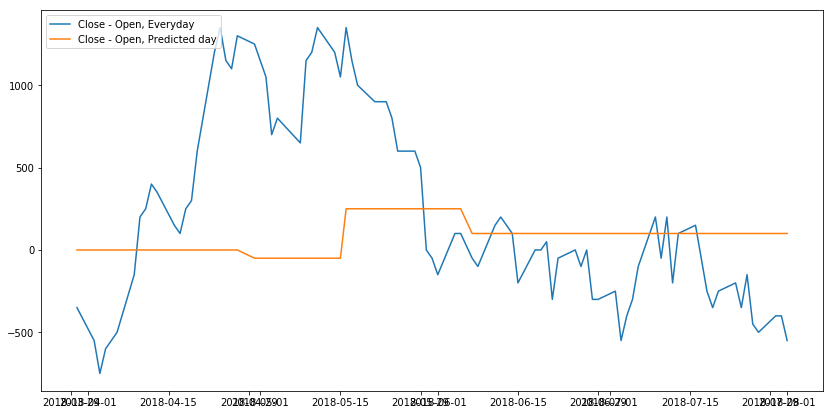

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib


fig, ax1 = plt.subplots(figsize=(14, 7))

# ax1.plot(predicted.index, predicted['m0c'])
# ax1.xaxis.set_major_locator(matplotlib.ticker.LinearLocator(13))

# ax2.plot(predicted.index, predicted['m1c'])


plt.plot(predicted.index,predicted['m0c'], label='Close - Open, Everyday')

ax1.plot(predicted.index,predicted['m1c'], label = 'Close - Open, Predicted day')
ax1.legend(loc='upper left')
# plt.set_major_locator(matplotlib.ticker.LinearLocator(5))
plt.savefig("1.png")

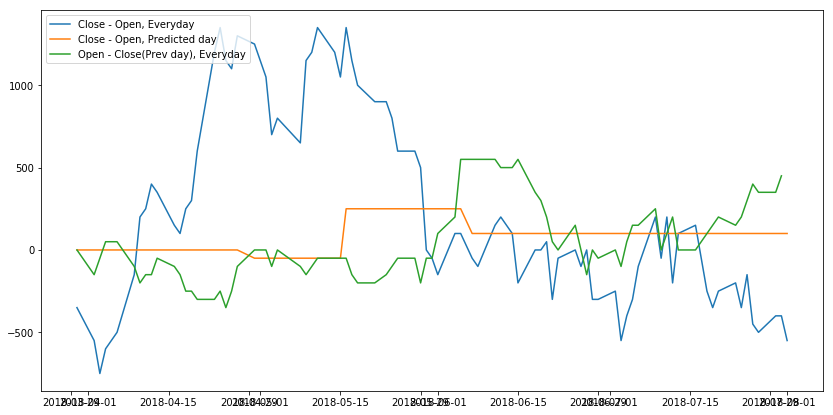

In [27]:
fig = plt.subplots(figsize=(14, 7))

plt.plot(predicted.index,predicted['m0c'], label='Close - Open, Everyday')

plt.plot(predicted.index,predicted['m1c'], label = 'Close - Open, Predicted day')
plt.plot(predicted.index, predicted['tomc'], label = 'Open - Close(Prev day), Everyday')
# plt.plot(predicted.index, predicted['tom_close_c'], label = 'Close - Close(Prev day), Everyday')
plt.legend(loc='upper left')
# plt.set_major_locator(matplotlib.ticker.LinearLocator(5))
plt.savefig("2.png")

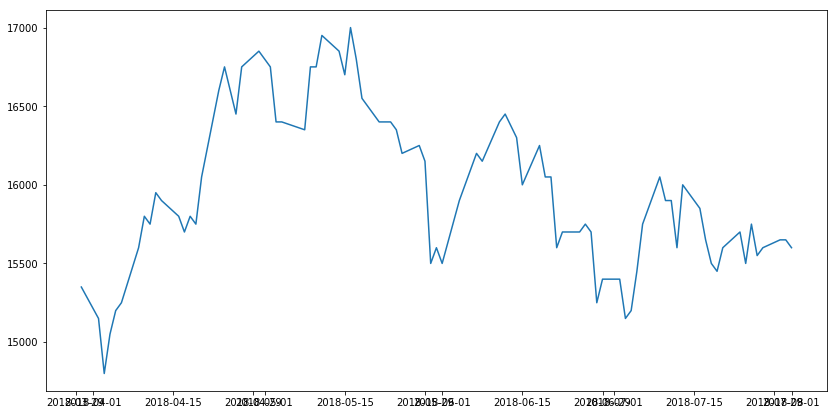

In [28]:
fig, ax1 = plt.subplots(figsize=(14, 7))
plt.plot(predicted.index,predicted['close'])

# 할 일
### 논리적인 문제가 없는지 검토 - 없는 듯함. 끝.
### 무작정 분석한 것과 결과값 비교 - 감성사전 안 하고 빈도수로만. 
### for 구문으로 사전 값을 데이터 프레임에 넣는 부분 속도 개선 방법 알아보기
### 3년 데이터로 (2년 train, 1년 test) 검토
### 가장 좋은 시간 범위 알아내기
### 가장 좋은 분석 방법 알아내기
### 수익 그래프 그리기 (투자금 1000만원으로 했을 때 수익금 계산하기)
### 1 % 상승 시와 2 % 상승 시 비교하기

SyntaxError: invalid syntax (<ipython-input-498-d948cf3f2c12>, line 2)

In [31]:
전처리 - 감성사전 방법. 
2개 classification 3개로 - 바꾼 기준 

시각화 - 워드 크라우드 -> power 값을 가지고 민경씨가.
주가 그래프를 - power 값이 제일 높은 거? 제일 낮은 거? 올랐을 때 떨어졌을 때 

이해, 분석 - 10가지? 종목에 대해서 각각의 prediction, crosstab - 1개 정도만 // 10개 종목 테이블에 넣어서 평균 값 

추천액션 - 시가 매수, 종가 매도 / 시가 매수, 다음날 시가 매도 / 시가 매수 + 3일 or + 7일 
          n번 랜덤으로 뽑아서? 
          
further study - 기간 늘려서 / 100 종목 전체에 대해 / 

SyntaxError: invalid syntax (<ipython-input-31-0c69c3e54cb6>, line 1)

In [32]:
어떤 종목을 ? 

SyntaxError: invalid syntax (<ipython-input-32-6fbd8e32830c>, line 1)

In [33]:
종목 : 29 - 38
오늘 할 일 민경씨 워드 크라우드 3년치 아무 거나 하나 삼성생명 
지윤씨 - 무작정 돌리는 거 해보기
진영 - 수익 그래프 쪽 코드 쓰고

SyntaxError: invalid syntax (<ipython-input-33-36c49e7786bb>, line 2)

## Train

In [34]:
train= a.make_s_matrix(train)

AttributeError: 'float' object has no attribute 'lower'

In [98]:
power = a.train_word_power(train)

In [99]:
emo_train = a.train_score(train, power)

In [100]:
emo_train

,00,000,000만,000억,000원,01,02,04,05,06,...,흥분,흥행,희망,희생,희석,희화화,히트,히트작,힙합,score
date,,,,,,,,,,,,,,,,,,,,,
20170801,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.000000,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-7.429650
20170802,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.000000,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-3.954115
20170803,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.000000,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-14.957203
20170804,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.000000,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-41.529407
20170807,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.000000,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-6.877503
20170808,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.000000,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-18.829287
20170809,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.000000,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-16.476840
20170810,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.000000,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-8.199992
20170811,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.318182,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,1.210578


In [101]:
corr_sum = a.train_confusion(train, emo_train)

In [102]:
corr_sum



0.7909836065573771

## Test

In [29]:
test= a.make_s_matrix(test)

AttributeError: 'float' object has no attribute 'lower'

In [104]:
emo_test = a.test_score(power, test, emo_train)

In [30]:
emo_test

NameError: name 'emo_test' is not defined

In [106]:
t_conf = a.test_confusion(test, emo_test)

In [107]:
t_conf

0.639344262295082